In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from LearningAlgorithms import ClassificationAlgorithms
import seaborn as sns
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

In [3]:
df =  pd.read_pickle('../../data/interim/03_data_features.pkl')

In [4]:
df_train =  df.drop(['participant' , 'category' , 'set'] , axis= 1)

In [5]:
X = df_train.drop('label' , axis = 1)
y = df_train['label']

 Create a training and test set

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42 , stratify=y)

<AxesSubplot: xlabel='label'>

<Figure size 1200x600 with 0 Axes>

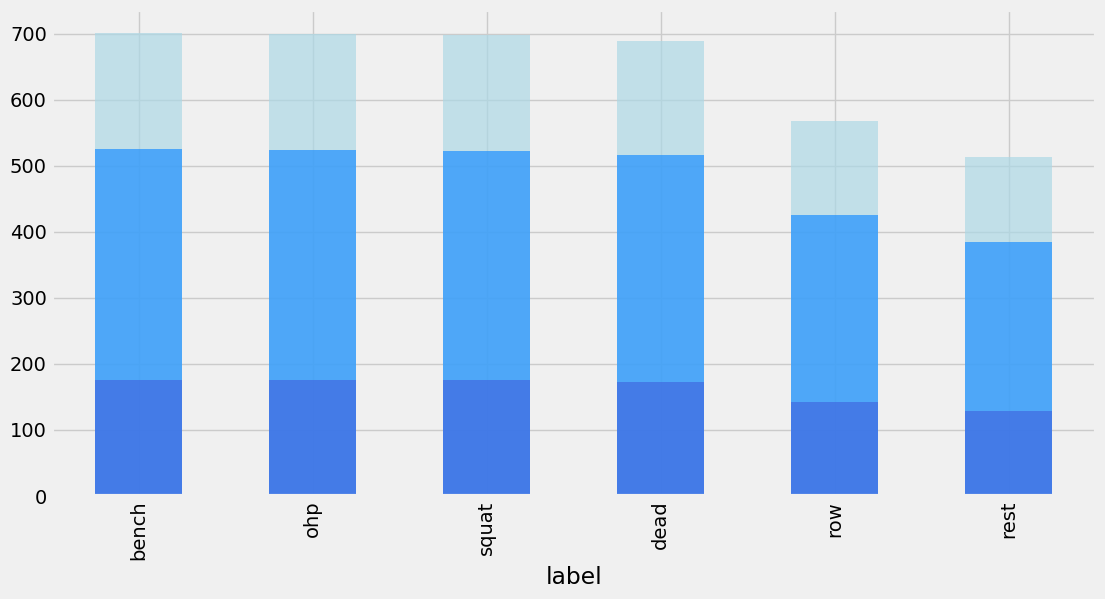

In [13]:
# Create figure and axes
plt.figure(figsize=(12,6))
fig, ax = plt.subplots(figsize=(12,6))

# Plot data
df_train['label'].value_counts().plot(
    kind='bar', 
    ax=ax, 
    color='lightblue', 
    label='Total Data',
    alpha=0.7  # Add slight transparency
)

y_train.value_counts().plot(
    kind='bar', 
    ax=ax, 
    color='dodgerblue', 
    label='Train Data',
    alpha=0.7
)

y_test.value_counts().plot(
    kind='bar', 
    ax=ax, 
    color='royalblue', 
    label='Test Data',
    alpha=0.7
)

In [7]:
y_train.value_counts()
y_test.value_counts()

label
bench    175
ohp      175
squat    175
dead     172
row      142
rest     128
Name: count, dtype: int64

#Split feature subsets

In [8]:
basic_features = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']
sqaure_feature = ['acc_r' , 'gyr_r']
pca_features = ['pca_1', 'pca_2', 'pca_3']
time_feature = [f for f in df_train.columns if '_temp_' in f]
freq_feature = [f for f in df_train.columns if ('_freq' in f) or ('_pse' in f)]
cluster_feature = ['cluster']

In [9]:
# Define all feature sets in a dictionary for easy iteration
feature_sets = {
    "Basic Features": basic_features,
    "Square Features": sqaure_feature,
    "PCA Features": pca_features,
    "Time Features": time_feature,
    "Frequency Features": freq_feature,
    "Cluster Features": cluster_feature,
}

# Loop through the dictionary and print feature set names with their lengths
for name, features in feature_sets.items():
    print(f"{name}: {len(features)} ")


Basic Features: 6 
Square Features: 2 
PCA Features: 3 
Time Features: 16 
Frequency Features: 88 
Cluster Features: 1 


#split up the different features into subsets, 
 inorder to check whether 
 additional features that added during feature enginnering phase are
 beneficial to predictive performance of the model

In [11]:
feature_set_1 = basic_features
feature_set_2 = list(set(basic_features + sqaure_feature + pca_features)) # put into set first to remove any duplicates
feature_set_3 = list(set(feature_set_2 + time_feature ))
feature_set_4 = list(set(feature_set_3 + freq_feature + cluster_feature  ))

# Perform forward feature selection using simple decision tree
based on training data

In [14]:
learner = ClassificationAlgorithms()
max_features = 10
selected_features, ordered_features, ordered_scores = learner.forward_selection( max_features , X_train ,y_train)

0
1
2
3
4
5
6
7
8
9


In [17]:
selected_features,ordered_scores

(['pca_1',
  'duration',
  'acc_z_freq_0.0_Hz_ws_14',
  'acc_y_temp_mean_ws_5',
  'gyr_x_freq_1.071_Hz_ws_14',
  'acc_y_freq_weighted',
  'acc_r_freq_2.143_Hz_ws_14',
  'acc_y_freq_0.357_Hz_ws_14',
  'acc_z',
  'acc_r'],
 [0.8876249569114099,
  0.9762150982419855,
  0.9979317476732161,
  0.9996552912788693,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0])

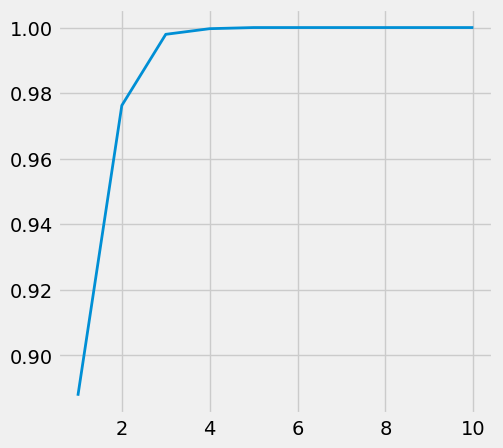

In [19]:
plt.figure(figsize=(5,5))
plt.plot(range(1 , len(selected_features)+1) , ordered_scores )
plt.show()

In [20]:
possible_feature_sets = [
    feature_set_1,
    feature_set_2,
    feature_set_3,
    feature_set_4,
    selected_features
]

feature_names = [
    'feature_set_1',
    'feature_set_2',
    'feature_set_3',
    'feature_set_4',
    'selected_features'
]

# Grid search for best hyperparameters and model selection

In [24]:
iterations = 1
score_df = pd.DataFrame()

In [25]:
for i, f in zip(range(len(possible_feature_sets)), feature_names):
    print("Feature set:", i)
    selected_train_X = X_train[possible_feature_sets[i]]
    selected_test_X = X_test[possible_feature_sets[i]]

    # First run non deterministic classifiers to average their score.
    performance_test_nn = 0
    performance_test_rf = 0

    for it in range(0, iterations):
    # First run non deterministic classifiers to average their score.
    
        print("\tTraining random forest,", it)
        (
            class_train_y,
            class_test_y,
            class_train_prob_y,
            class_test_prob_y,
        ) = learner.random_forest(
            selected_train_X, y_train, selected_test_X, gridsearch=True
        )
        performance_test_rf += accuracy_score(y_test, class_test_y)

    # performance_test_nn = performance_test_nn / iterations
    performance_test_rf = performance_test_rf / iterations

    # And we run our deterministic classifiers:
    print("\tTraining KNN")
    selected_train_X = np.array(selected_train_X)
    selected_test_X = np.array(selected_test_X)
    (
    class_train_y,
    class_test_y,
    class_train_prob_y,
    class_test_prob_y,
    ) = learner.k_nearest_neighbor(
        selected_train_X, y_train, selected_test_X, gridsearch=True
    )
    performance_test_knn = accuracy_score(y_test, class_test_y)

    print("\tTraining decision tree")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.decision_tree(
        selected_train_X, y_train, selected_test_X, gridsearch=True
    )
    performance_test_dt = accuracy_score(y_test, class_test_y)

    print("\tTraining naive bayes")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.naive_bayes(selected_train_X, y_train, selected_test_X)

    performance_test_nb = accuracy_score(y_test, class_test_y)

    # Save results to dataframe
    models = [ "RF", "KNN", "DT", "NB"]
    new_scores = pd.DataFrame(
        {
            "model": models,
            "feature_set": f,
            "accuracy": [
                
                performance_test_rf,
                performance_test_knn,
                performance_test_dt,
                performance_test_nb,
            ],
        }
    )
    score_df = pd.concat([score_df, new_scores])

Feature set: 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 1
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 2
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 3
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 4
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes


# Create a grouped bar plot to compare the results

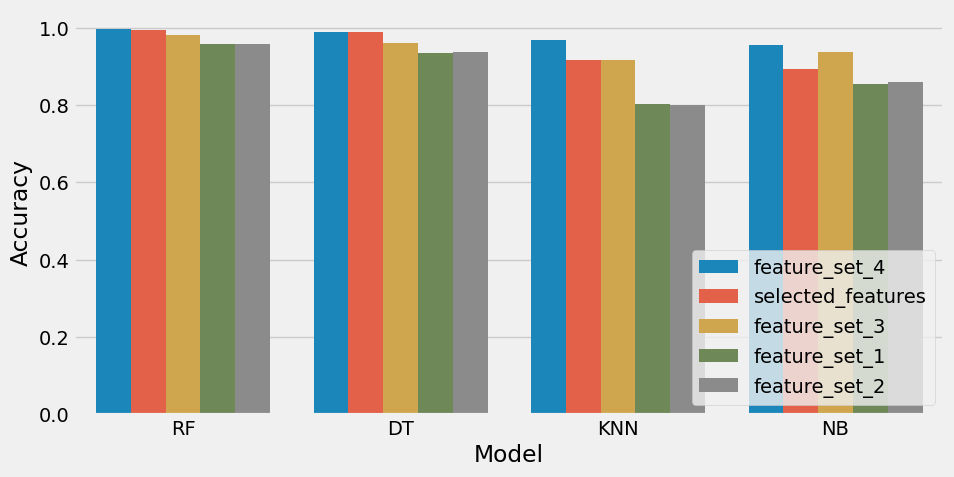

In [28]:
score_df = score_df.sort_values(by = 'accuracy' , ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(data= score_df , x = 'model' , y= 'accuracy' , hue='feature_set')
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.show()

# Select best model and evaluate results

In [29]:
#Train Random Forest Model
(class_train_y, class_test_y, class_train_prob_y, class_test_prob_y,) = learner.random_forest( 
    X_train[feature_set_4], y_train, X_test[feature_set_4],
    gridsearch=True
    )

#Random forest accuracy

In [31]:
accuracy=accuracy_score(y_test ,class_test_y) 
accuracy

0.9948293691830403

In [32]:
classes =  class_test_prob_y.columns
cm = confusion_matrix(y_test ,class_test_y ,labels=classes)

# create confusion matrix for cm

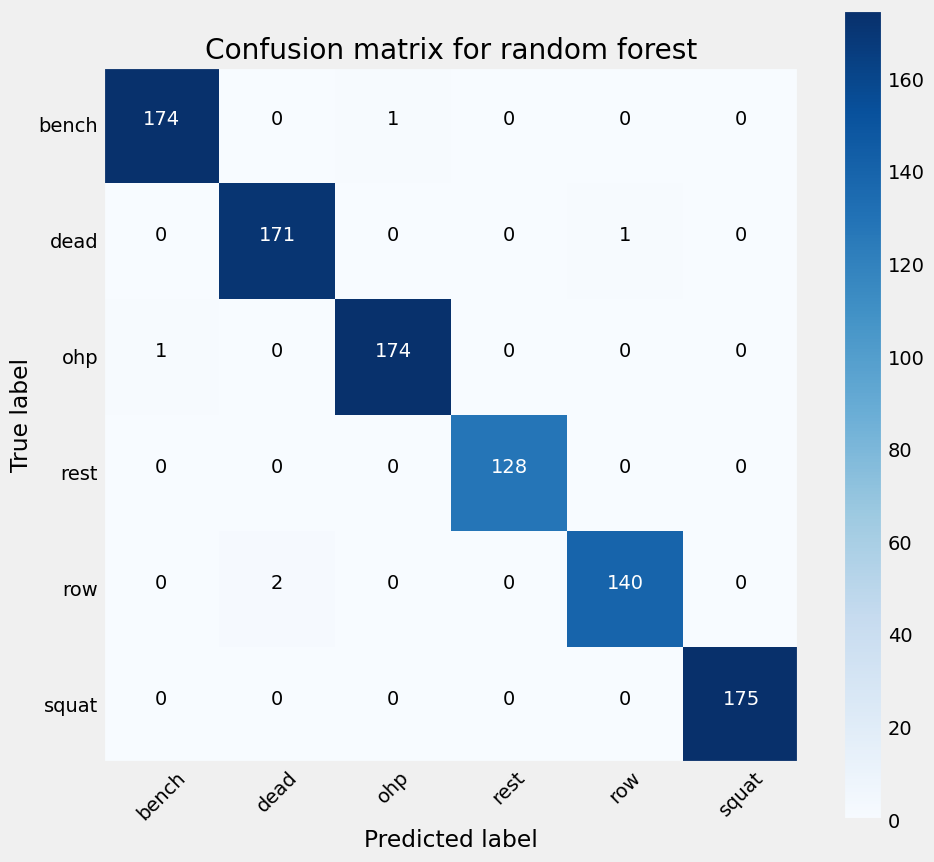

In [33]:
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix for random forest")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.grid(False)
plt.show()

# Select train and test data based on participant

In [34]:
participant_df =  df.drop(['set' , 'category'] ,axis = 1)

X_train =  participant_df[participant_df['participant'] != 'A'].drop('label' , axis = 1)
y_train =  participant_df[participant_df['participant'] != 'A']['label']

X_test =  participant_df[participant_df['participant'] == 'A'].drop('label' , axis = 1)
y_test =  participant_df[participant_df['participant'] == 'A']['label']


X_train= X_train.drop('participant' ,axis = 1)
X_test = X_test.drop('participant' ,axis = 1)

# Use best model again and evaluate results

In [35]:
(class_train_y, class_test_y, class_train_prob_y, class_test_prob_y,) = learner.random_forest( 
    X_train[feature_set_4], 
    y_train, 
    X_test[feature_set_4], 
    gridsearch=True)


#Random forest accuracy

In [36]:
accuracy=accuracy_score(y_test ,class_test_y) 
accuracy

0.9938080495356038

In [37]:
classes =  class_test_prob_y.columns
cm = confusion_matrix(y_test ,class_test_y ,labels=classes)

#confusion matrix for random forest based on participant

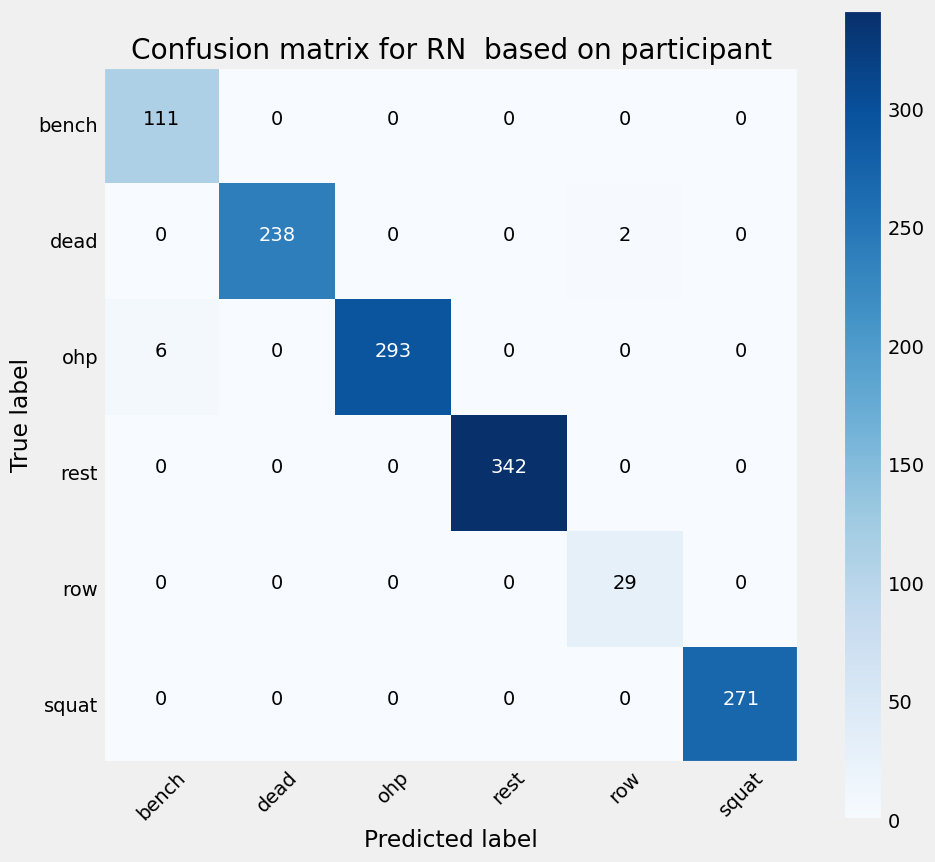

In [38]:
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix for RN  based on participant")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.grid(False)
plt.show()

# Try Decision trees with the selected features

In [39]:
(class_train_y, class_test_y, class_train_prob_y, class_test_prob_y,) = learner.decision_tree( 
                      X_train[selected_features], 
                      y_train, 
                      X_test[selected_features], 
                      gridsearch=True)

In [41]:
accuracy=accuracy_score(y_test ,class_test_y) 
accuracy

0.9690402476780186

In [ ]:
#confusion matrix

In [43]:
classes =  class_test_prob_y.columns
cm = confusion_matrix(y_test ,class_test_y ,labels=classes)


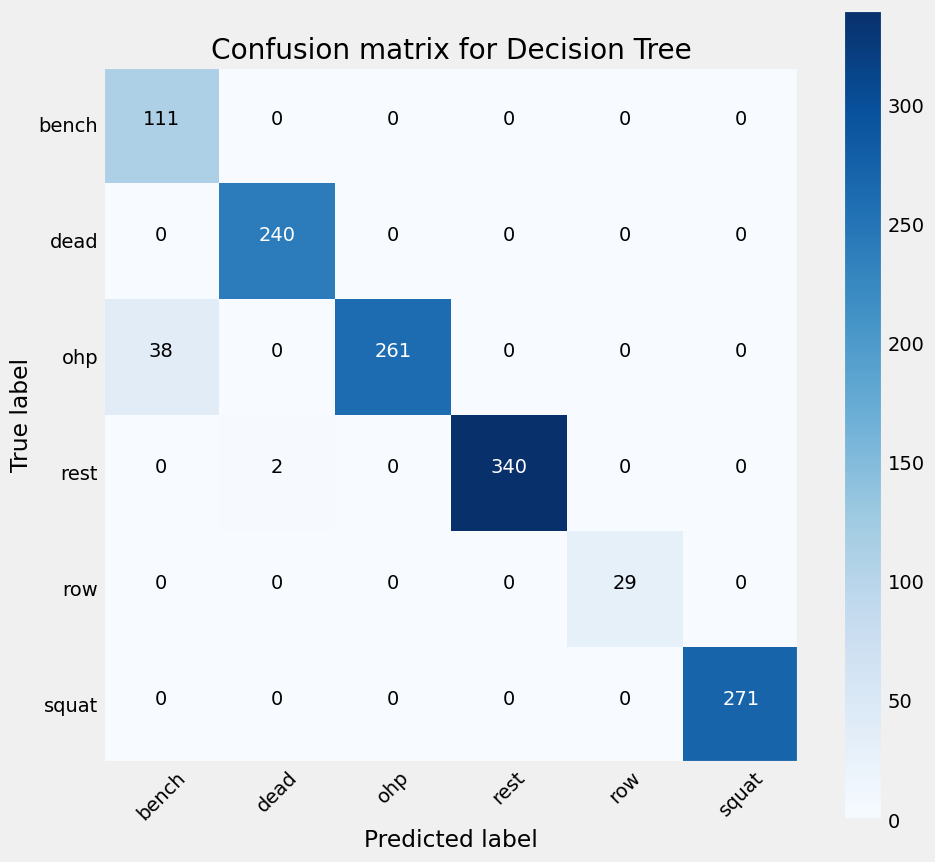

In [44]:
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix for Decision Tree")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.grid(False)
plt.show()